# Compare Explanations of Probabilities with SHAP
[SHAP docs:](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)
> Note that explaining the probability of a linear logistic regression model is not linear in the inputs.

In [1]:
from matplotlib.colors import ListedColormap
from shap.maskers import Independent
from sklearn.decomposition import PCA
from imldiff.linearly_separable.loader import load_data
from imldiff.linearly_separable.models import LogisticRegressionModel, DecisionTreeModel
from imldiff.linearly_separable.explainers import SHAPExplainer
from imldiff.util import printmd
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = load_data(n_samples=200)
feature_names = ['x1', 'x2']
linear_model = LogisticRegressionModel()
linear_model.train(X, y)
tree_based_model = DecisionTreeModel()
tree_based_model.train(X, y)
models = [linear_model, tree_based_model]

Finished training: ../models/LogisticRegressionModel (0:00:00.017588)
Finished training: ../models/DecisionTreeModel (0:00:00.001001)


## Decision Boundaries

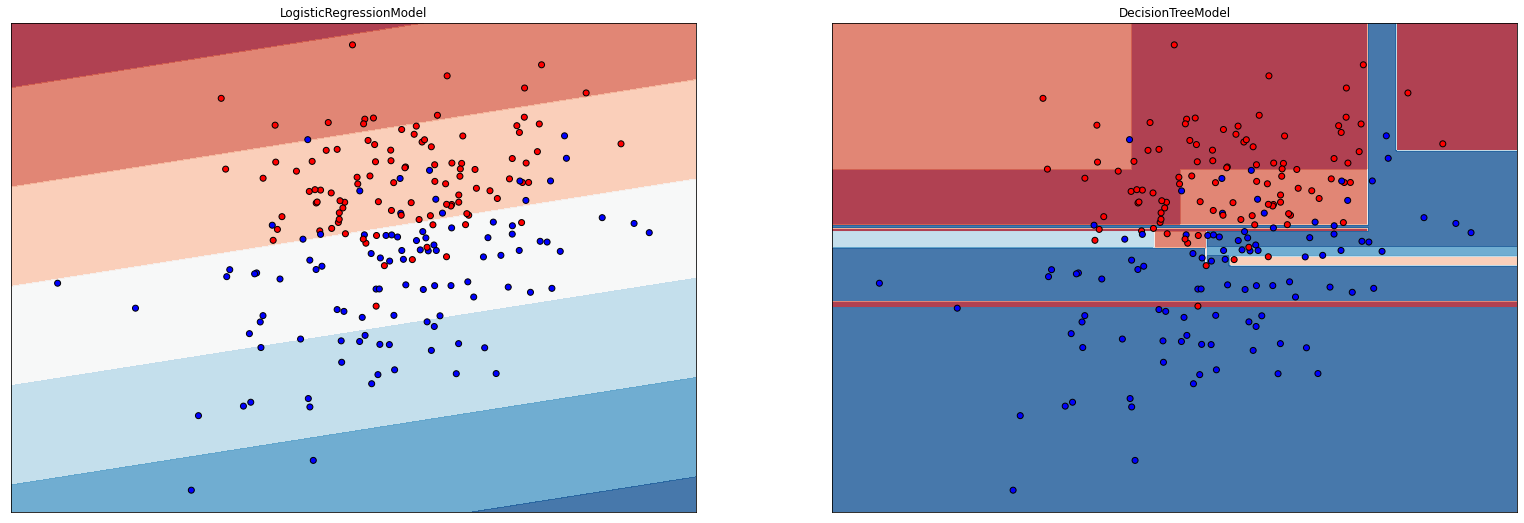

In [3]:
figure = plt.figure(figsize=(27, 9))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

i = 1

for model in models:
    ax = plt.subplot(1, len(models), i)
    clf = model.model

    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(model)

    i += 1

In [4]:
X_sample, y_sample = X, y

In [5]:
linear_model_explainer = SHAPExplainer('Linear Classifier Probability')
linear_model_explainer.generate(linear_model.predict_proba, X_sample)
linear_model_explainer.feature_names = feature_names

Finished generating: explanations/Linear Classifier Probability.exp (0:00:04.987503)


In [6]:
tree_based_model_explainer = SHAPExplainer('Tree-based Classifier Probability')
tree_based_model_explainer.generate(tree_based_model.predict_proba, X_sample)
tree_based_model_explainer.feature_names = feature_names

Finished generating: explanations/Tree-based Classifier Probability.exp (0:00:00.972279)


In [7]:
explainers = [linear_model_explainer, tree_based_model_explainer]
last_explainer = explainers[-1]

## Scatter plots
They are generalizations of the partial dependence plots.

With the parameter color, we instruct SHAP to pick the feature that has the biggest interaction effects with the explained feature and to colour the observations according to its' shapeley values.

In [8]:
def scatter_plot(feature_name):
    printmd(f'### {feature_name}')
    for explainer in explainers:
        shap.plots.scatter(explainer.shap_values[:, feature_name], color=explainer.shap_values, title=explainer.identifier)

### x1

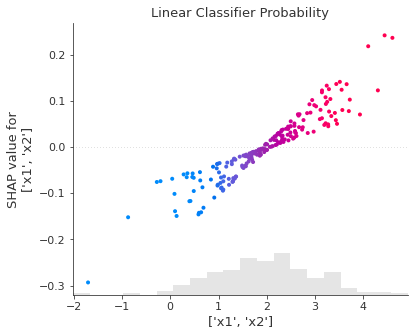

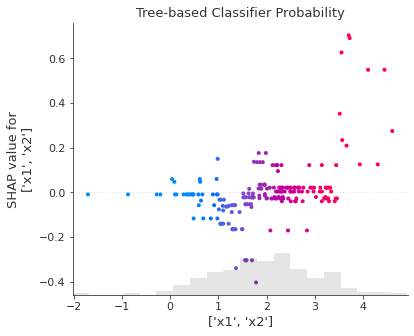

In [9]:
scatter_plot('x1')

### x2

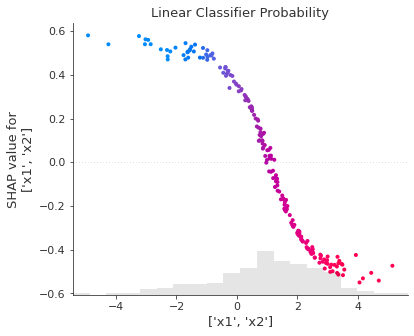

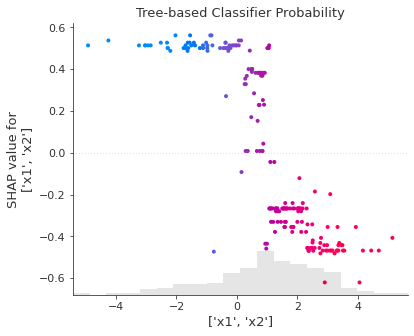

In [10]:
scatter_plot('x2')

## Bar plots

### Linear Classifier Probability

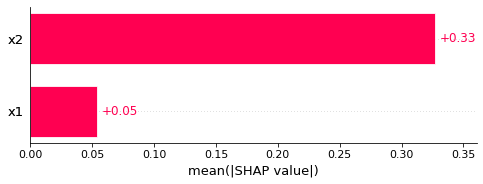

### Tree-based Classifier Probability

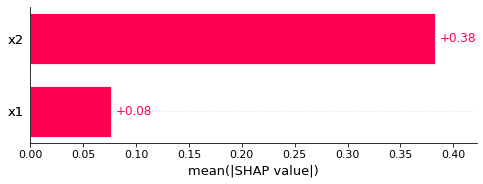

In [11]:
order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.bar(explainer.shap_values, max_display=len(feature_names), order=order)

> But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrewuent but high magnitude effects.

### Linear Classifier Probability

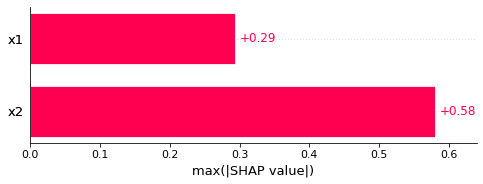

### Tree-based Classifier Probability

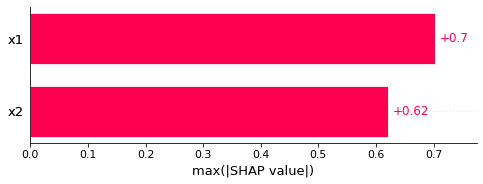

In [12]:
order = np.argsort(-last_explainer.shap_values.abs.max(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.bar(explainer.shap_values.abs.max(0), max_display=len(feature_names), order=order)

## Beeswarm plots
They show the Shapeley value distribution per feature.
> If we are willing to deal with a bit more complexity we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

### Linear Classifier Probability

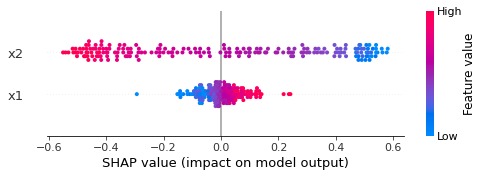

### Tree-based Classifier Probability

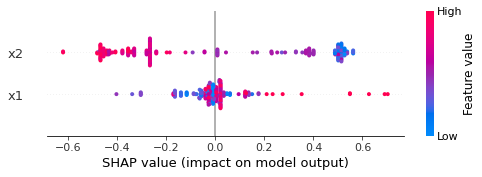

In [13]:
order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.beeswarm(explainer.shap_values, order=order)

> By taking the absolute value and using a solid color we get a compromise between the complexity of the bar plot and the full beeswarm plot. Note that the bar plots above are just summary statistics from the values shown in the beeswarm plots below.

### Linear Classifier Probability

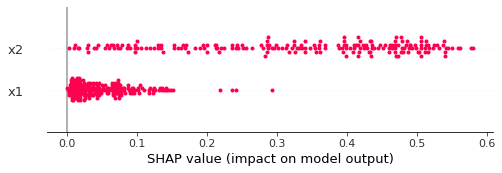

### Tree-based Classifier Probability

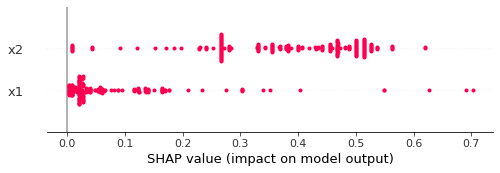

In [14]:
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.beeswarm(explainer.shap_values.abs, color="shap_red", order=order)

Or we  could simplify the visualization of the distribution by using violin plots:

### Linear Classifier Probability

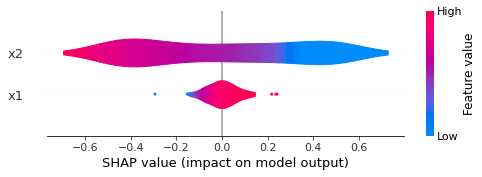

### Tree-based Classifier Probability

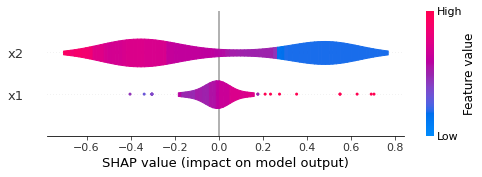

In [15]:
# unfortunately, violin plot has no option to set the order
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.violin(explainer.shap_values.values, features=explainer.shap_values.data, feature_names=feature_names)

## Forceplot

In [16]:
shap.initjs()

In [17]:
last_plot = shap.plots.force(
    base_value=last_explainer.shap_values.abs.mean(0).base_values,
    shap_values=last_explainer.shap_values.values,
    features=last_explainer.shap_values.display_data,
    feature_names=feature_names,
    out_names=last_explainer.identifier)
ordering = list(map(lambda x: int(x['simIndex']), last_plot.data['explanations']))

In [18]:
def force_plot(explainer):
    printmd(f'### {explainer.identifier}')
    return shap.plots.force(
        base_value=explainer.shap_values.abs.mean(0).base_values,
        shap_values=explainer.shap_values.values,
        features=explainer.shap_values.display_data,
        feature_names=feature_names,
        out_names=explainer.identifier,
        ordering_keys=ordering)

In [19]:
force_plot(explainers[0])

### Linear Classifier Probability

In [20]:
force_plot(explainers[1])

### Tree-based Classifier Probability

## Plot embeddings
Use the SHAP values as an embedding which we project to 2D for visualization, using PCA.

### Linear Classifier Probability

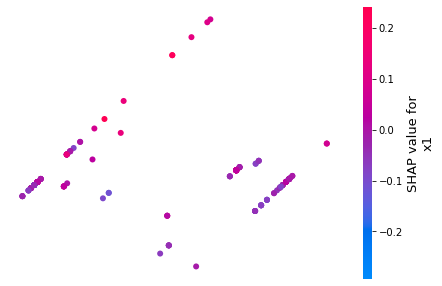

### Tree-based Classifier Probability

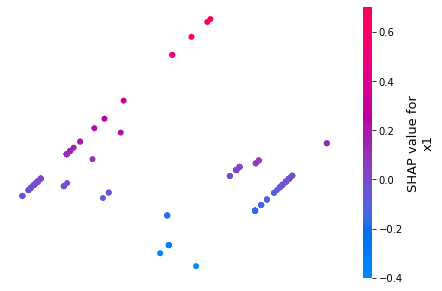

In [21]:
pca = PCA(2)
embedding_values = pca.fit_transform(last_explainer.shap_values.values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.embedding('x1', explainer.shap_values.values, feature_names=feature_names, method=embedding_values)

## Heatmap
Here we use a supervised hierarchical clustering method to visualize the SHAP values

### Linear Classifier Probability

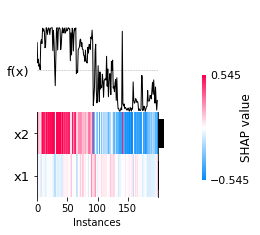

### Tree-based Classifier Probability

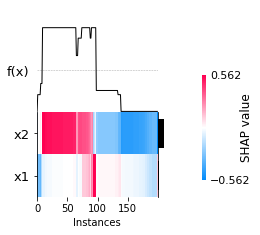

In [22]:
instance_order = last_explainer.shap_values.hclust()
feature_order = np.argsort(-last_explainer.shap_values.abs.mean(0).values)
for explainer in explainers:
    printmd(f'### {explainer.identifier}')
    shap.plots.heatmap(explainer.shap_values, instance_order=instance_order, feature_order=feature_order, max_display=len(feature_names))